In [53]:
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set(font_scale=1.5,style="whitegrid")

In [2]:
def add_confidence(row, agg_data):
    data = agg_data[agg_data['id'] == row['id']]
    return data.iloc[0]['label:confidence']


def load_dataset(folder):
    def add_fields(df,iteration):
        df['iteration'] = iteration
        df['domain'] = folder[0].split('-')[0]
        return df
         
    agg_list = []
    full_list = []
    test_list = []
    new_a = re.compile(r'[^>]+(?=:\[OBJECT_A\])')
    new_b = re.compile(r'[^>]+(?=:\[OBJECT_B\])')
    for f in folder:

        iteration = 2 if 'it3' in f else 1
        agg = pd.read_csv('{}/agg.csv'.format(f))
        agg = add_fields(agg,iteration)
        agg['raw_text'] = agg.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)
        
        agg['a'] = agg.apply(lambda row:  new_a.findall(row['text_html'])[0], axis=1)
        agg['b'] = agg.apply(lambda row:  new_b.findall(row['text_html'])[0], axis=1)
        
        agg_list.append(agg)
        
        
        full = pd.read_csv('{}/full.csv'.format(f))
        full = add_fields(full,iteration)
        full_list.append(full)
        
        test = pd.read_csv('{}/test.csv'.format(f))
        test = add_fields(test,iteration)
        test_list.append(test)
    return pd.concat(agg_list), pd.concat(full_list), pd.concat(test_list)
   
        

In [3]:
jbt_agg, jbt_full, jbt_test = load_dataset(['jbt-data', 'jbt-data-it2','jbt-data-it3'])
compsci_agg, compsci_full, compsci_test = load_dataset(['compsci-data', 'compsci-data-it2', 'compsci-data-it3'])
brands_agg, brands_full, brands_test = load_dataset(['brands-data-100', 'brands-data-400', 'brands-data-it2', 'brands-data-it3'])

In [4]:
columns = ['id','domain', 'object_a', 'object_b', 'sentence', 'it_1_confidence', 'it_2_confidence', 
           'better_count', 'worse_count','none_count', 'most_frequent_label', 'most_frequent_count', 
           'it_1_judgments', 'it_2_judgments', 'sentence_html']


def add_columns(agg,full):
    df = pd.DataFrame(columns=columns)
    for sid in full['id'].unique():
        better_count = 0
        better_trust = 0
        worse_count = 0
        worse_trust = 0
        none_count = 0
        none_trust = 0
        it_1_judgments = 0
        it_2_judgments = 0
        most_frequent = ''
        f_subset = full[full['id'] == sid]
        for i, f_row in f_subset.iterrows():
            label = f_row['label']
            _iteration = f_row['iteration']
            if _iteration == 1:
                it_1_judgments +=1
            else:
                it_2_judgments += 1
                
            if 'BETTER' == label:
                better_count +=1
                better_trust += f_row['_trust']
            elif 'WORSE' == label:
                worse_count += 1
                worse_trust += f_row['_trust']
            else:
                none_count +=1
                none_trust += f_row['_trust']
        winner = sorted([(better_trust, better_count, 'BETTER'), (worse_trust, worse_count, 'WORSE'),
                         (none_trust, none_count, 'NONE')],reverse=True)
        most_frequent_label = winner[0][2]
        most_frequent_count = winner[0][1]
        
        a_it1 = agg[(agg['id'] == sid) & (agg['iteration'] == 1)]
        a_it2 = agg[(agg['id'] == sid) & (agg['iteration'] == 2)]
        

        if len(a_it1) == 1 and len(a_it2) == 1:
            content = [sid,a_it1.iloc[0]['domain'], a_it1.iloc[0]['a'], a_it1.iloc[0]['b'],a_it1.iloc[0]['raw_text'],
                       a_it1.iloc[0]['label:confidence'],a_it2.iloc[0]['label:confidence'],
                       better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,a_it1.iloc[0]['text_html']]
            df.loc[len(df)] =content
    
    df['judgments'] = df['it_1_judgments'] + df['it_2_judgments']
    it1_c = df['it_1_confidence'] * (df['it_1_judgments']/ df['judgments'])
    it2_c = df['it_2_confidence'] * (df['it_2_judgments']/ df['judgments'])
    df['confidence'] = it1_c+it2_c
    
    df['most_frequent_percentage'] = df['most_frequent_count'] / df['judgments']
    numeric_cols =['confidence', 'most_frequent_count', 'most_frequent_percentage','judgments']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

    
    return df

In [5]:
compsci = add_columns(compsci_agg,compsci_full)

In [6]:
brands = add_columns(brands_agg,brands_full)

In [7]:
jbt = add_columns(jbt_agg,jbt_full)

In [8]:
combi = pd.concat([compsci,brands,jbt])
combi = combi[combi.judgments > 4]

In [9]:
print('All rows: {} Unique: {}'.format(len(combi), len(combi['sentence'])))

All rows: 7199 Unique: 7199


In [10]:
combi[['object_a', 'object_b','sentence','most_frequent_label']].sample(10)

,object_a,object_b,sentence,most_frequent_label
16,pizza,soup,This is because the ingredients used in pizza ...,NONE
1437,Toyota,Chevrolet,It was introduced to us North Americans in 201...,NONE
1999,wii,gamecube,Haven't felt this mad since Nintendo delayed T...,NONE
7,PHP,JavaScript,"You can do form checking with PHP, but it is m...",WORSE
2115,michigan,pennsylvania,Romney's abandoned michigan as well as pennsyl...,NONE
1493,Java,Scala,So I write in Java (Scala actually) because it...,NONE
967,Java,Ruby,"Java, .NET, PHP, Ruby, etc.).",NONE
1382,coffee,juice,Upgraded staples : decent toilet paper; gourme...,NONE
1745,Bluetooth,USB,"After browsing the article, I didn't see anyth...",BETTER
1138,california,oregon,I changed employers once after that in order t...,WORSE


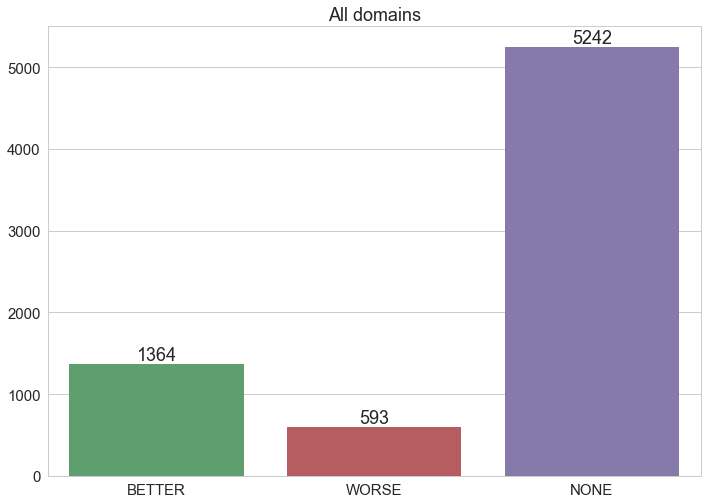

In [96]:
pal = sns.color_palette()[1:]
def dist_plot(data,title='',max_y=5500,order=['BETTER','WORSE','NONE']):
    fig, ax = plt.subplots()
    sns.countplot(x="most_frequent_label",palette=pal,order=order, data=data);
    plt.xlabel('')
    plt.ylabel('')
    fig.set_size_inches(11.7, 8.27)
    t = title if len(title) > 0 else data.domain.unique()[0].capitalize()
    plt.title(t)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        max_y = max(y,max_y)
        ax.annotate('{}'.format(int(y)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    plt.ylim(ymax = max_y,ymin=0)
    fig.savefig("{}-dist.pdf".format(t.replace(' ','')))
dist_plot(combi,'All domains')

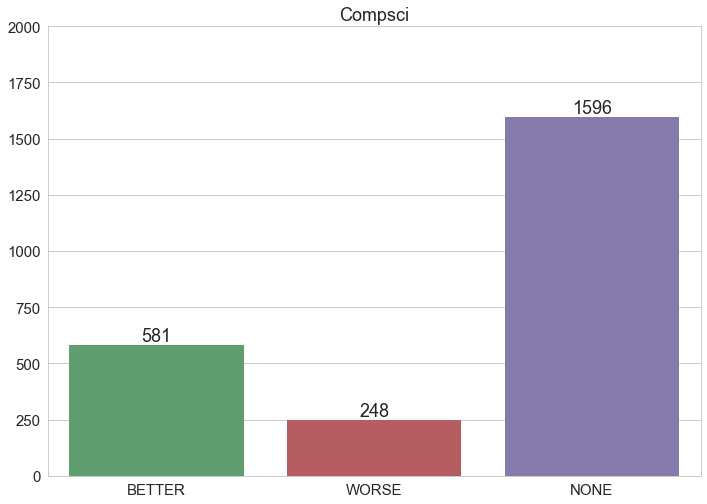

In [89]:
dist_plot(combi[combi.domain == 'compsci'],max_y=2000)

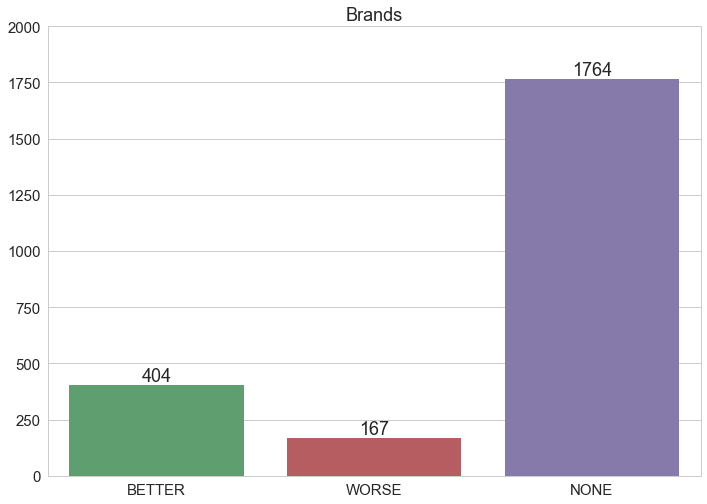

In [90]:
dist_plot(combi[combi.domain == 'brands'],max_y=2000)

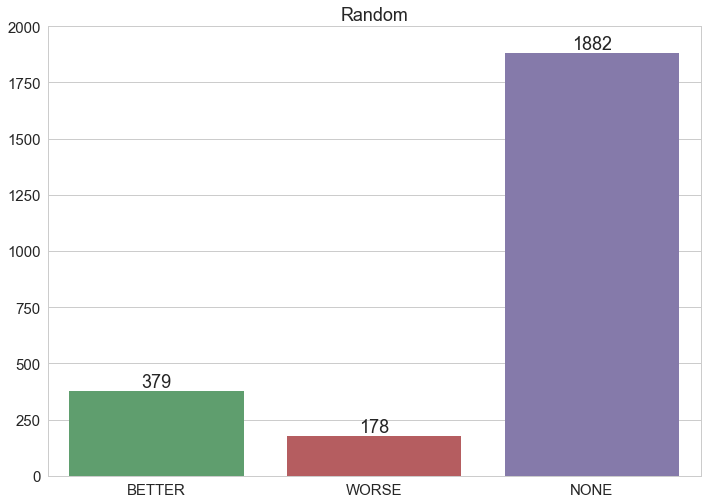

In [91]:
dist_plot(combi[combi.domain == 'jbt'],max_y=2000,title='Random')

In [13]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(combi,stratify=combi['most_frequent_label'], test_size=0.2,random_state=42)
print('{} {} {}'.format(len(train_i), len(test_i), (len(train_i)+ len(test_i))))
combi.to_csv('all-data.csv',index=False)
train_i.to_csv('data.csv',index=False)
test_i.to_csv('held-out-data.csv',index=False)
train_i.most_frequent_label.value_counts()

5759 1440 7199


NONE      4194
BETTER    1091
WORSE      474
Name: most_frequent_label, dtype: int64

In [17]:
from collections import defaultdict
from pprint import pprint

pairs = defaultdict(int)
for i,row in combi[combi.domain == 'jbt'].iterrows():
    p = ' vs. '.join(sorted([row['object_a'].lower(), row['object_b'].lower()]))
    pairs[p] += 1

pprint(pairs)
print(len(pairs))

defaultdict(<class 'int'>,
            {'aluminum vs. metal': 14,
             'aluminum vs. steel': 17,
             'amazon vs. facebook': 18,
             'amazon vs. google': 22,
             'amazon vs. hulu': 26,
             'amazon vs. itunes': 22,
             'amazon vs. youtube': 18,
             'baseball vs. basketball': 17,
             'baseball vs. football': 22,
             'baseball vs. golf': 12,
             'baseball vs. hockey': 12,
             'baseball vs. softball': 24,
             'baseball vs. tennis': 20,
             'basketball vs. football': 19,
             'basketball vs. golf': 20,
             'basketball vs. hockey': 9,
             'basketball vs. softball': 13,
             'basketball vs. tennis': 19,
             'basketball vs. volleyball': 14,
             'beer vs. champagne': 9,
             'beer vs. cider': 16,
             'beer vs. coffee': 12,
             'beer vs. juice': 13,
             'beer vs. milk': 10,
             'beer vs. 

In [18]:
from collections import defaultdict
d = defaultdict(int)
ks = ['100','91-99','81-90','71-80','61-70','51-60','0-50']
ds = brands
for v in ds['most_frequent_percentage']:
    if v == 1:
        d['100'] +=1
    elif v >= 0.91 and v <= 99:
        d['91-99'] += 1
    elif v >= 0.81 and v <= 90:
        d['81-90'] += 1
    elif v >= 0.71 and v <= 80:
        d['71-80'] += 1
    elif v >= 0.61 and v <= 70:
        d['61-70'] += 1
    elif v >= 0.51 and v <= 60:
        d['51-60'] += 1
    else:
        d['0-50'] += 1

s = sum([v for k,v in d.items()])
assert s == len(ds)
res = sorted([(k, v, '{:02.2f}\%'.format(( (v/s) *100 ))) for k,v in d.items()], key=lambda x: x[1],reverse=True)

for r in ks:
    f = d[r]
    print('{}\%\t&\t{}\t&\t{:02.2f}\t \\\ '.format(r, f,(f/s)*100))

100\%	&	1719	&	71.30	 \\ 
91-99\%	&	0	&	0.00	 \\ 
81-90\%	&	34	&	1.41	 \\ 
71-80\%	&	337	&	13.98	 \\ 
61-70\%	&	8	&	0.33	 \\ 
51-60\%	&	256	&	10.62	 \\ 
0-50\%	&	57	&	2.36	 \\ 


In [19]:
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
display(combi[combi.most_frequent_percentage <= 0.5][['sentence','object_a', 'object_b', 'better_count', 'worse_count', 'none_count']])

,sentence,object_a,object_b,better_count,worse_count,none_count
36,"Unlike Windows 7, which provided Microsoft's large user base with an evolutionary path forward from Windows XP, with a look, feel and overall experience that was better - Windows 8 is a different beast.",Windows XP,Windows 8,2,2,1
65,Perl is slower and faster than Java,Perl,Java,2,1,2
121,"Goodnight NetBeans, Hello Eclipse",NetBeans,Eclipse,2,2,1
164,"The new version of the Groovy programming language aims to make life easier for programmers who work with Java and SQL, the language's developers note.",Groovy,Java,3,0,3
196,"This is most likely done to optimize for Integer calculations, rather than slower Floating-point math.",Integer,Floating-point,3,0,3
222,@Slava: FUD! Shameless FUD! Groovy is definitely not thousands times slower than Java!,Groovy,Java,3,1,2
278,This makes JavaScript in my experience harder to debug than Python.,JavaScript,Python,2,4,2
280,The process of converting it to Java resulted in a 100x speed up - despite Perl possibly having a faster regex implementation.,Java,Perl,2,1,2
314,"The GIS functions of MySQL, and even better ones of PostgreSQL, make light work of this, but I started simply.",MySQL,PostgreSQL,3,3,0
325,"CUDA is still strong because it has better support, but we all want OpenCL to win out in the long run (even if they have to update it majorly before that happens)",CUDA,OpenCL,3,2,1


### other figs

In [104]:
def dist_plot_cust(p,order,title='',max_y=500):
    manually_labelled = pd.DataFrame(columns=['most_frequent_label','domain'])
    idx = 1
    for label, cnt in p:
        for i in range(cnt):
            manually_labelled.loc[idx] = [label,'']
            idx+=1
    dist_plot(manually_labelled,order=order,max_y=max_y)

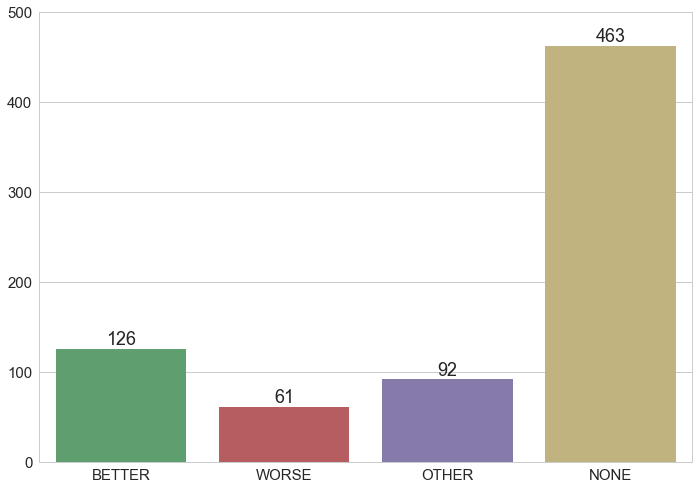

In [105]:
# manually labelled
dist_plot_cust([('NONE',463),('BETTER',126),('WORSE',61),('OTHER',92)],
               ['BETTER','WORSE','OTHER','NONE'],title='',max_y=500)

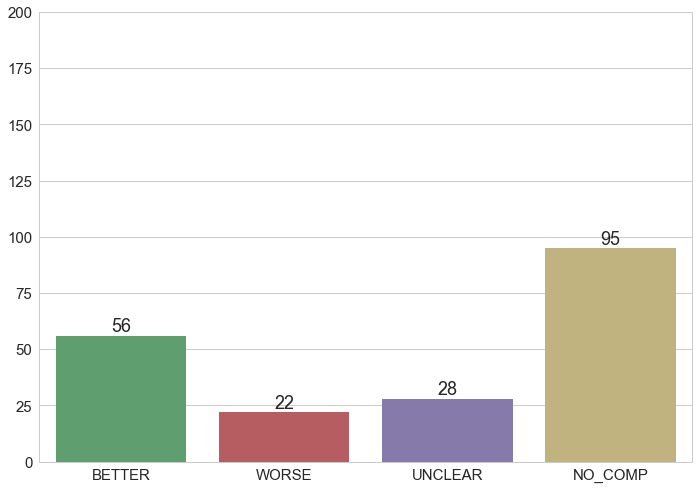

In [106]:
# prestudy b
dist_plot_cust([('NO_COMP',95),('BETTER',56),('WORSE',22),('UNCLEAR',28)],
               ['BETTER','WORSE','UNCLEAR','NO_COMP'],title='',max_y=200)

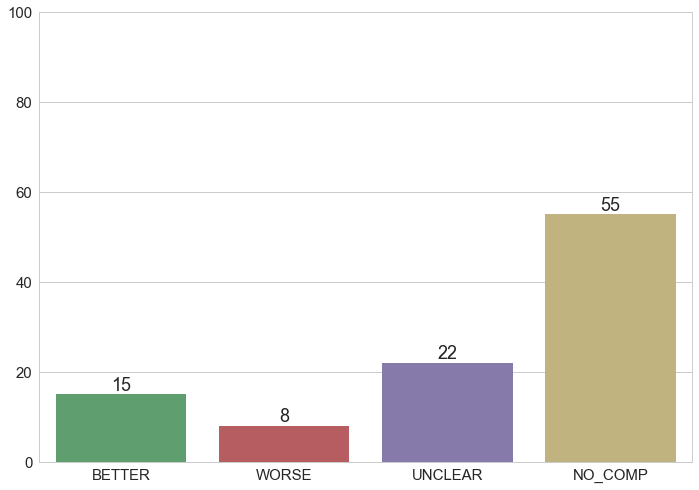

In [108]:
# prestudy a
dist_plot_cust([('NO_COMP',55),('BETTER',15),('WORSE',8),('UNCLEAR',22)],
               ['BETTER','WORSE','UNCLEAR','NO_COMP'],title='',max_y=100)